In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale, resize
from tqdm import tqdm
import cv2
import random

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
# KERAS IMPORTS
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import concatenate, add
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import Conv2DTranspose
# from tensorflow.keras.layers import MaxPool2D, AvgPool2D
# from tensorflow.keras.layers import UpSampling2D
# # from tensorflow.keras.layers.advanced_activations import LeakyReLU
# from tensorflow.keras.layers import LeakyReLU
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Lambda
# from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Reshape
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import Add, Multiply
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.losses import mse, binary_crossentropy

# import tensorflow.keras.backend as K
# from tensorflow.keras.utils import multi_gpu_model

import tensorflow as tf
import keras
from keras.layers import concatenate, add
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.utils import plot_model
from keras.layers import Add, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import mse, binary_crossentropy
from keras import initializers
import keras.backend as K
from keras.utils import multi_gpu_model
from sklearn.metrics import confusion_matrix

/home/manu_kohli/anaconda3/envs/test_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/manu_kohli/anaconda3/envs/test_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/manu_kohli/anaconda3/envs/test_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/manu_kohli/anaconda3/e

In [3]:
# Set some parameters
im_width = 128
im_height = 128
n_channels = 3
border = 5
n_filters=8
dropout=0.05
batchnorm=True
path_train = './Dataset/Compaq_orignal/Compaq_orignal/Compaq_orignal/train/'
path_valid = './Dataset/Compaq_orignal/Compaq_orignal/Compaq_orignal/test/'
path_test = './Dataset/Compaq_orignal/test_NIR/'

In [4]:
import cv2
def get_data(train_data_path):
    img_size = 128
#     train_ids = next(os.walk(train_data_path))[1]
    train_ids = next(os.walk(train_data_path + "image/1"))[2]
    x_train = []
#     x_train = np.zeros((len(train_ids), img_size, img_size, 3), dtype=np.uint8)
    y_train = np.zeros((len(train_ids), img_size, img_size, 1), dtype=np.bool)

    for i, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
        path = train_data_path+"image/1"+"/{}".format(id_)
        img = cv2.imread(path,1)
        img = cv2.resize(img, (img_size, img_size))
        img = np.asarray(img) / 127.5
        img = img - 1
        x_train.append(img)

        height, width, _ = img.shape
        label = np.zeros((height, width, 1))
        path2 = train_data_path+"label/1/"
        mask_ = cv2.imread(path2+id_, 0)
        mask_ = cv2.resize(mask_, (img_size, img_size))
        mask_ = np.expand_dims(mask_, axis=-1)
        label = np.maximum(label, mask_)
        y_train[i]=label
    x_train = np.array(x_train)
    y_train = np.asarray(y_train).astype(np.uint8)
    return x_train , y_train
X_train, y_train = get_data(path_train)
X_valid , y_valid = get_data(path_valid)
X_test , y_test = get_data(path_test)

/home/manu_kohli/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


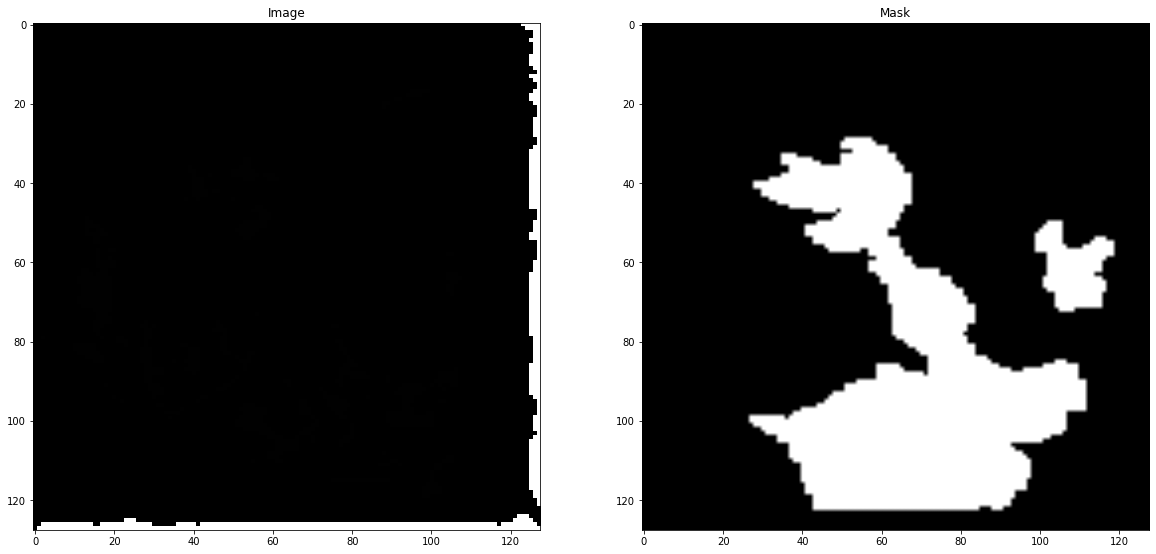

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# image = X_train[ix, ... , 0]
image = X_train[ix,:,:,:].reshape(128,128,3)
# image = (image + 1 ) / 2
# image = image * 255
ax[0].imshow(image.astype('uint8'))
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

In [6]:
#SET A SEED FOR REPRODUCABILITY
np.random.seed(20)

#NUMBER OF DIMENSIONS IN THE ENCODED LAYER
latent_dims = 64
image_size = 128
n_channel = 3

In [7]:
def edge_comp(image):
    edge = tf.image.sobel_edges(image)
    edge = concatenate([edge[:,:,:,:,0],edge[:,:,:,:,1]],axis = -1)
    print(edge.shape)
    return edge

In [8]:
#ENCODER
#BUILT WITH FUNCTIONAL MODEL DUE TO THE MULTIPLE INPUTS AND OUTPUTS

encoder_in = Input(shape=(image_size,image_size,n_channel),name = 'encoder_input')   ##INPUT FOR THE IMAGE

input_edge = Lambda(edge_comp)(encoder_in)

encoder_l1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', input_shape=(image_size,image_size,n_channel),kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_in)
# encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)

encoder_l1 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l1)
# encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l1)
# encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = Activation(LeakyReLU(0.2))(encoder_l2)

encoder_l3 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l2)
# encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = Activation(LeakyReLU(0.2))(encoder_l3)


encoder_l4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l3)
# encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l4 = Activation(LeakyReLU(0.2))(encoder_l4)

encoder_l5 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_l4)
# encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l5 = Activation(LeakyReLU(0.2))(encoder_l5)

flatten = Flatten()(encoder_l5)

encoder_dense = Dense(1024,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(flatten)
# encoder_dense = BatchNormalization()(encoder_dense)
encoder_out = Activation(LeakyReLU(0.2))(encoder_dense)


mu = Dense(latent_dims,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_out)
log_var = Dense(latent_dims,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model(inputs = [encoder_in,epsilon], outputs =[z,input_edge],name='encoder')
print(encoder.summary())

(?, 128, 128, 6)
(?, 128, 128, 6)
Instructions for updating:
Colocations handled automatically by placer.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        encoder_input[0][0]              
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  73856       activation_1[0][0]  

/home/manu_kohli/anaconda3/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [9]:
## DECODER
# # layer 1
decoder_in = Input(shape=(latent_dims,),name='decoder_input')
decoder_edge = Input(shape = (image_size,image_size,6),name = 'edge_input')
decoder_l1 = Dense(1024, input_shape=(latent_dims,),kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_in)
# decoder_l1 = BatchNormalization()(decoder_l1)
decoder_l1 = Activation(LeakyReLU(0.2))(decoder_l1)
#layer 2
decoder_l2 = Dense(2048,kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l1)
# decoder_l2 = BatchNormalization()(decoder_l2)
decoder_l2 = Activation(LeakyReLU(0.2))(decoder_l2)
#reshape 
decoder_reshape = Reshape(target_shape=(4,4,128))(decoder_l2)
# layer 3
decoder_l3 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_reshape)
# decoder_l3 = BatchNormalization()(decoder_l3)
decoder_l3 = Activation(LeakyReLU(0.2))(decoder_l3)
#layer 4 
decoder_l4 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l3)
# decoder_l4 = BatchNormalization()(decoder_l4)
decoder_l4 = Activation(LeakyReLU(0.2))(decoder_l4)
#layer 5 
decoder_l5 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l4)
# decoder_l5 = BatchNormalization()(decoder_l5)
decoder_l5 = Activation(LeakyReLU(0.2))(decoder_l5)
#layer 6
decoder_l6 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l5)
# decoder_l6 = BatchNormalization()(decoder_l6)
decoder_l6 = Activation(LeakyReLU(0.2))(decoder_l6)
#layer 7
# decoder_l7 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l6)
# # decoder_l7 = BatchNormalization()(decoder_l7)
# decoder_l7 = Activation(LeakyReLU(0.2))(decoder_l7)
#layer 8
decoder_l8 = Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same',kernel_initializer = initializers.RandomNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l6)
# decoder_l8 = BatchNormalization()(decoder_l8)
# decoder_l8 = Activation(LeakyReLU(0.2))(decoder_l8)
decoder_l8 = Activation('tanh')(decoder_l8)
decoder_ledge = concatenate([decoder_l8,decoder_edge],axis = -1)

#layer 9
decoder_l9 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_ledge)
# decoder_l9 = BatchNormalization()(decoder_l9)
decoder_l9 = Activation(LeakyReLU(0.2))(decoder_l9)

decoder_l10 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l9)
# decoder_l9 = BatchNormalization()(decoder_l9)
decoder_l10 = Activation(LeakyReLU(0.2))(decoder_l10)

decoder_l11 = Conv2D(filters=3, kernel_size=3, strides=1, padding='same',kernel_initializer = initializers.TruncatedNormal(stddev=0.02),bias_initializer=initializers.Constant(value=0.0))(decoder_l10)
# decoder_l9 = BatchNormalization()(decoder_l9)
decoder_out = Activation('tanh')(decoder_l11)

decoder=Model(inputs = [decoder_in , decoder_edge],outputs = [decoder_out],name='vae_decoder')
print(decoder.summary())

Model: "vae_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 64)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         66560       decoder_input[0][0]              
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 1024)         0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2048)         2099200     activation_8[0][0]               
________________________________________________________________________________________

In [10]:
# COMBINE ENCODER AND DECODER THE COMPLETE THE VARIATIONAL AUTO ENCODER
encoder_out,edge_input = encoder([encoder_in,epsilon])
decoder_out = decoder([encoder_out,edge_input])
vae = Model([encoder_in, epsilon], decoder_out)
vae = multi_gpu_model(vae, gpus=4)
vae.summary()

(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
(?, 128, 128, 6)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           encoder_input[0][0]              
__________________________________________________________________________________________________
lambda_4 (Lambda)    

In [11]:
# MY LOSS FUNCTIONS

def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) + K.mean(K.abs(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return 10* reconstruction_loss(y_true, y_pred) +  1 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help

In [12]:
opt = keras.optimizers.RMSprop(lr=0.0001 , decay=1e-3)
vae.compile(optimizer=opt, loss=vae_loss , metrics=[reconstruction_loss,kl_loss])
callbacks = [
    EarlyStopping(patience=15, verbose=1,monitor='val_loss'),
    ReduceLROnPlateau(monitor = 'val_loss',factor=0.5, patience=3, min_lr=0.000001, verbose=1,mode='max',cooldown=2),
    ModelCheckpoint('./models/vae_skin_keras/vae_b16/vae_final_batch64.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
history=vae.fit(X_train,X_train,
                epochs=150,
                batch_size=64,
                validation_data = (X_valid,X_valid),
               callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 3268 samples, validate on 1400 samples
Epoch 1/150
3268/3268 [==============================] - 47s 14ms/step - loss: 7.4122 - reconstruction_loss: 0.7416 - kl_loss: 1.4489e-05 - val_loss: 7.0506 - val_reconstruction_loss: 0.7047 - val_kl_loss: 3.7356e-07

Epoch 00001: val_loss improved from inf to 7.05063, saving model to ./models/vae_skin_keras/vae_b16/vae_final_batch64.h5
Epoch 2/150
3268/3268 [==============================] - 36s 11ms/step - loss: 6.9831 - reconstruction_loss: 0.6976 - kl_loss: 0.0216 - val_loss: 6.7509 - val_reconstruction_loss: 0.6746 - val_kl_loss: 2.0889e-05

Epoch 00002: val_loss improved from 7.05063 to 6.75092, saving model to ./models/vae_skin_keras/vae_b16/vae_final_batch64.h5
Epoch 3/150
3268/3268 [==============================] - 35s 11ms/step - loss: 6.7791 - reconstruction_loss: 0.6804 - kl_loss: 0.0093 - val_loss: 68419.5869 - val_reconstruction_loss: 0.7106 - val_kl_loss: 68412.4766

Epoch 00

3268/3268 [==============================] - 34s 11ms/step - loss: 2.5639 - reconstruction_loss: 0.2225 - kl_loss: 0.3396 - val_loss: 2.5853 - val_reconstruction_loss: 0.2247 - val_kl_loss: 0.3376

Epoch 00051: val_loss did not improve from 2.58354
Epoch 52/150
3268/3268 [==============================] - 35s 11ms/step - loss: 2.5618 - reconstruction_loss: 0.2217 - kl_loss: 0.3397 - val_loss: 2.5942 - val_reconstruction_loss: 0.2255 - val_kl_loss: 0.3380

Epoch 00052: val_loss did not improve from 2.58354
Epoch 53/150
3268/3268 [==============================] - 35s 11ms/step - loss: 2.5614 - reconstruction_loss: 0.2223 - kl_loss: 0.3397 - val_loss: 2.5946 - val_reconstruction_loss: 0.2256 - val_kl_loss: 0.3376

Epoch 00053: val_loss did not improve from 2.58354
Epoch 54/150
3268/3268 [==============================] - 36s 11ms/step - loss: 2.5624 - reconstruction_loss: 0.2226 - kl_loss: 0.3393 - val_loss: 2.5879 - val_reconstruction_loss: 0.2249 - val_kl_loss: 0.3378

Epoch 00054: val

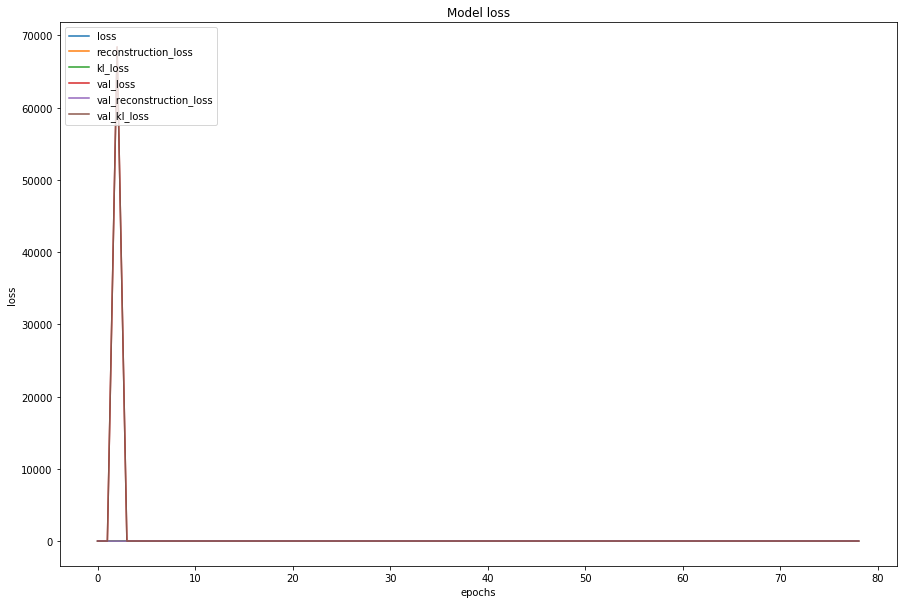

In [15]:
def showloss(history):
        # loss plot
        plt.subplots(figsize=(15,10))
        plt.subplot(1,1,1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['reconstruction_loss'])
        plt.plot(history.history['kl_loss'])
        plt.plot(history.history['val_loss'])
        plt.plot(history.history['val_reconstruction_loss'])
        plt.plot(history.history['val_kl_loss'])
        plt.title('Model loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['loss','reconstruction_loss','kl_loss','val_loss','val_reconstruction_loss','val_kl_loss'],loc = 'upper left')
showloss(history)

In [14]:
# vae.load_weights('./models/vae_skin_keras/vae_b16/vae_final.h5')

In [57]:
# model prediction 
train_vae_prediction = vae.predict(X_train,verbose = 1)
valid_vae_prediction = vae.predict(X_valid , verbose = 1)
test_vae_prediction = vae.predict(X_test , verbose = 1)

1240/1240 [==============================] - 5s 4ms/step


In [58]:
print(train_vae_prediction.shape)
print(valid_vae_prediction.shape)
print(test_vae_prediction.shape)

(3268, 128, 128, 3)
(1400, 128, 128, 3)
(1240, 128, 128, 3)


In [23]:
# image visualization
def visualizer(data , model):
    n=10
#     images = next(iter(data))[0]
    images = data[:20]
    predictions = model.predict(images)
    print(predictions.shape)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        orig = images[i,:,:,:].reshape(128,128,3)
        orig = (orig +1)/2
        plt.imshow((255*orig).astype('uint8').squeeze() ,cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        pred = predictions[i,:,:,:].reshape(128,128,3)
        pred = (pred + 1)/2
        plt.imshow((255*pred).astype('uint8').squeeze(),cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


(20, 128, 128, 3)


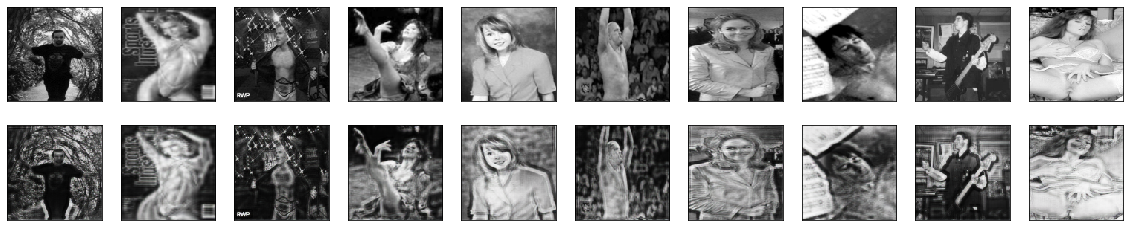

(20, 128, 128, 3)


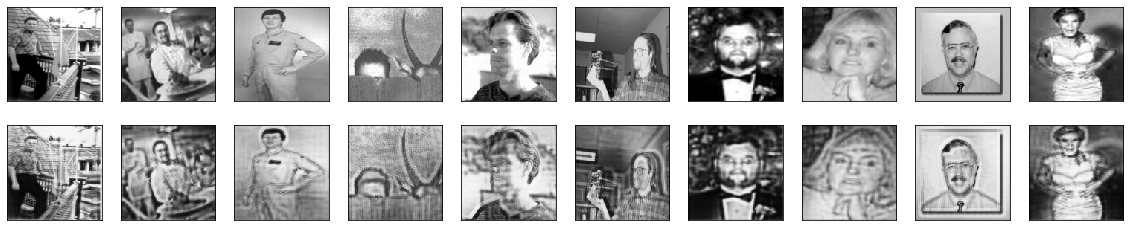

(20, 128, 128, 3)


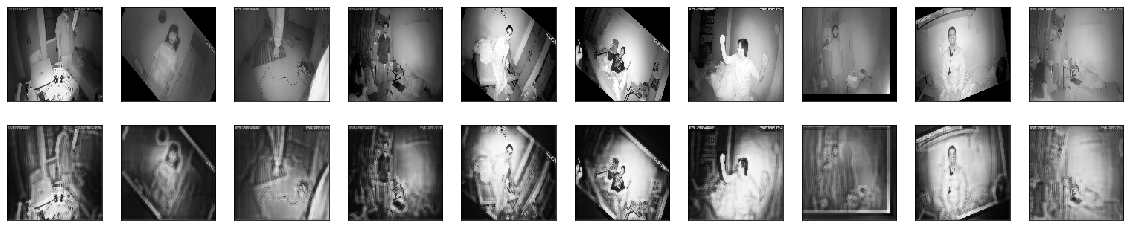

In [24]:
visualizer(X_train , vae)
visualizer(X_valid , vae)
visualizer(X_test , vae)

In [ ]:
#load images 

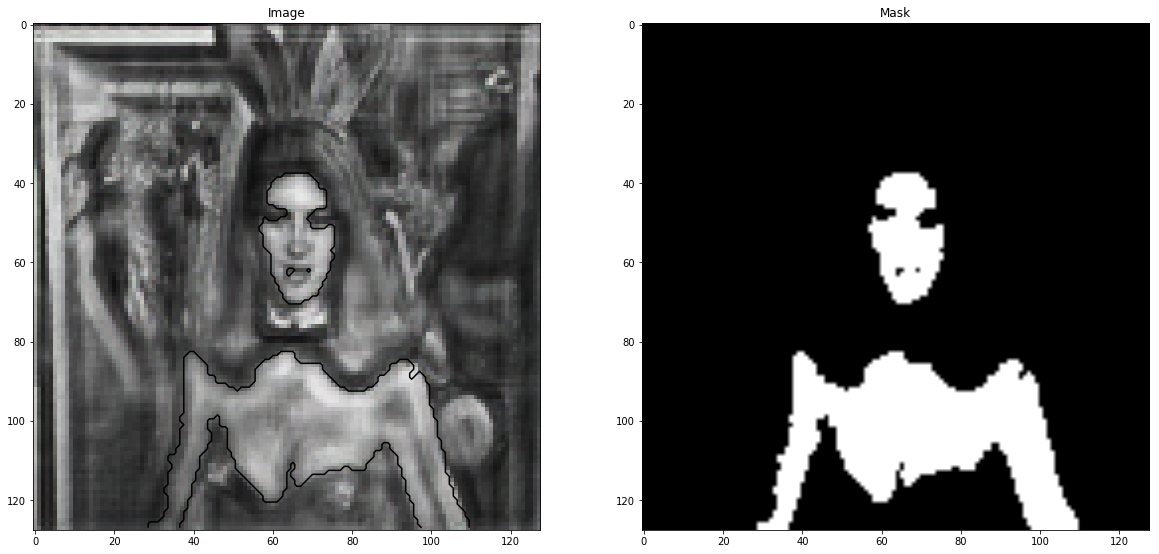

In [36]:
#check image pair 
# Check if training data looks all right
ix = random.randint(0, len(train_vae_prediction))
print()
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# image = X_train[ix, ... , 0]
image = train_vae_prediction[ix,:,:,:].reshape(128,128,3)
image = (image + 1 ) / 2
image = image * 255
ax[0].imshow(image.astype('uint8'))
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

In [37]:
ix

1538

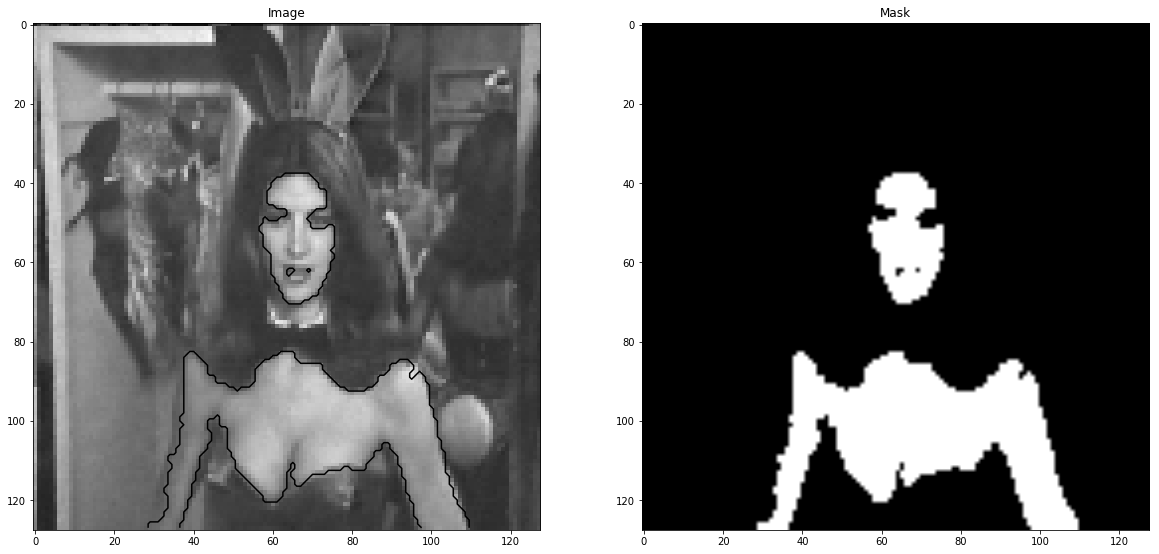

In [39]:
#check image pair 
# Check if training data looks all right
# ix = random.randint(0, len(train_vae_prediction))
ix = 1538
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# image = X_train[ix, ... , 0]
image = X_train[ix,:,:,:].reshape(128,128,3)
image = (image + 1 ) / 2
image = image * 255
ax[0].imshow(image.astype('uint8'))
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

In [48]:
# # import efficientnet 
# K.clear_session()
from efficientnet import EfficientNetB4

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x


def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model


In [49]:
# K.clear_session()
img_size = 128
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.20)
model.summary()

Model: "u-xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 64, 64, 48)   1296        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 64, 64, 48)   192         conv2d_169[0][0]                 
__________________________________________________________________________________________________
swish_97 (Swish)                (None, 64, 64, 48)   0           batch_normalization_145[0][0]    
_________________________________________________________________________________________

In [50]:
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [51]:
# model.compile(loss=bce_logdice_loss, optimizer=Adam(1e-4 , decay = 1e-6), metrics=[iou_metric,dice_coef])
model.compile(loss=bce_logdice_loss, optimizer=keras.optimizers.RMSprop(lr=0.0001 , decay=1e-3), metrics=[mean_iou,dice_coef,precision, recall, accuracy])

In [52]:
model.load_weights('./models/u-efficientnet/1/u-efficientnet_bce_meaniou_dice_oCompq_128_final.h5')

In [59]:
#denorm
def denorm(image):
    image = (image + 1) / 2
    image = image * 255.
    return image

X_train_norm = denorm(X_train)
X_valid_norm = denorm(X_valid)
X_test_norm = denorm(X_test)
train_vae_pred_norm = denorm(train_vae_prediction)
valid_vae_pred_norm = denorm(valid_vae_prediction)
test_vae_pred_norm = denorm(test_vae_prediction)

In [61]:
#evaluate 
score_train = model.evaluate(X_train_norm, y_train, verbose=1)
print(score_train)
score_valid = model.evaluate(X_valid_norm, y_valid, verbose=1)
print(score_valid)
score_test = model.evaluate(X_test_norm, y_test, verbose=1)
print(score_test)

3268/3268 [==============================] - 26s 8ms/step
[0.36019609534755037, 0.6304165720939636, 0.8498004078865051, 0.8199234008789062, 0.8827025294303894, 0.9435062408447266]
1400/1400 [==============================] - 11s 8ms/step
[0.5070900671822685, 0.5495526194572449, 0.7855911254882812, 0.7533115148544312, 0.8225598931312561, 0.918975830078125]
1240/1240 [==============================] - 10s 8ms/step
[1.6561821852960894, 0.1356290727853775, 0.2442762851715088, 0.3161875307559967, 0.20674358308315277, 0.9629673957824707]


In [72]:
#evaluate 
score_train_pred = model.evaluate(train_vae_pred_norm, y_train, verbose=1)
score_valid_pred = model.evaluate(valid_vae_pred_norm, y_valid, verbose=1)
score_test_pred = model.evaluate(test_vae_pred_norm, y_test, verbose=1)
print(score_train_pred)
print(score_valid_pred)
print(score_test_pred)

1240/1240 [==============================] - 10s 8ms/step
[0.8269153417542924, 0.3668064475059509, 0.6347172856330872, 0.8572195172309875, 0.5062608122825623, 0.8943520784378052]
[0.9488406092779977, 0.3295610547065735, 0.5886926054954529, 0.8059713244438171, 0.46633970737457275, 0.8825090527534485]
[2.3130047875065958, 0.06044606491923332, 0.11439117789268494, 0.10621671378612518, 0.13037629425525665, 0.9413414001464844]


In [73]:
#predict
# Predict on train, val and test
seg_train = model.predict(X_train_norm, verbose=1)
seg_train_pred = model.predict(train_vae_pred_norm, verbose=1)

# Threshold predictions
seg_train_t = (seg_train > 0.5).astype(np.uint8)
seg_train_pred_t = (seg_train_pred > 0.5).astype(np.uint8)

3268/3268 [==============================] - 25s 8ms/step


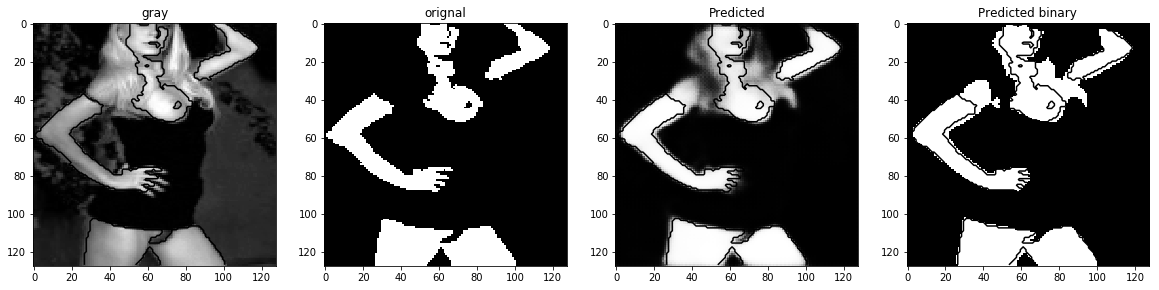

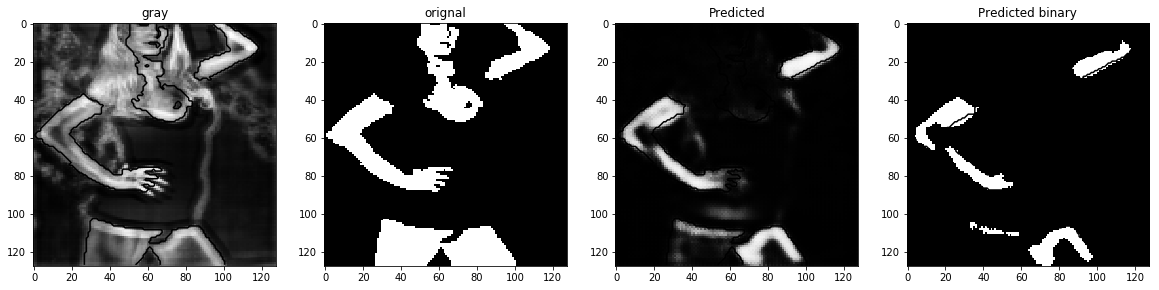

In [74]:
# visualize
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('gray')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('orignal')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');
# Check if training data looks all right
plot_sample(X_train, y_train, seg_train, seg_train_t, ix=14)

# Check if valid data looks all right
plot_sample(train_vae_prediction, y_train, seg_train_pred, seg_train_pred_t, ix=14)

In [91]:
def write_image(path_images ,path_masks, pred_image , pred_masks):
    for ix in range(len(pred_image)):
        file_name = ix
        image_path = str(path_images) + str(file_name) + ".jpg"
        mask_path = str(path_masks) + str(file_name) + ".jpg"
        image = pred_image[ix,:,:,:].reshape(image_size,image_size,3)
        image = (image+1)/2
        image = image*255.
        cv2.imwrite(image_path , image)
        mask = pred_masks[ix].reshape(image_size,image_size)
        mask = np.array(mask)
        cv2.imwrite(mask_path , mask)
path_images = '/home/manu_kohli/skin/Aayush/github/Skin_segmentation/VAE/predict_image/vae_pred/NIR/image/1/'
path_masks = '/home/manu_kohli/skin/Aayush/github/Skin_segmentation/VAE/predict_image/vae_pred/NIR/label/1/'
# write_image(path_images , path_masks ,train_vae_prediction ,y_train)
# write_image(path_images , path_masks ,valid_vae_prediction , y_valid)
write_image(path_images , path_masks ,test_vae_prediction , y_test)

In [92]:
write_image = '/home/manu_kohli/skin/Aayush/github/Skin_segmentation/VAE/predict_image/vae_pred/NIR/'
image_list, mask_list = get_data(write_image)

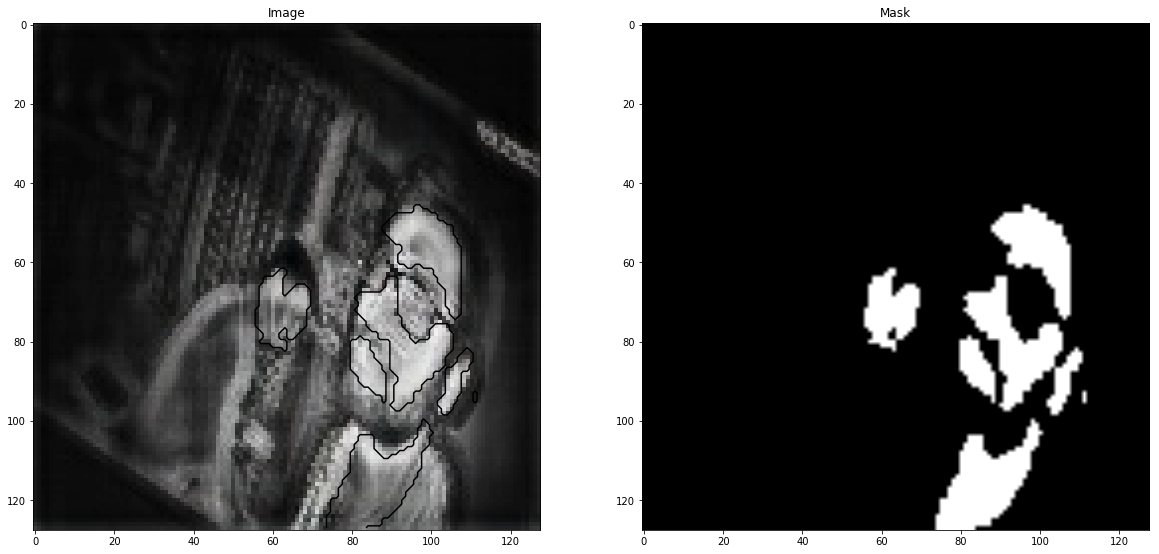

In [93]:
# Check if training data looks all right
ix = random.randint(0, len(image_list))
has_mask = mask_list[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# image = X_train[ix, ... , 0]
image = image_list[ix,:,:,:].reshape(128,128,3)
image = (image + 1 ) / 2
image = image * 255
ax[0].imshow(image.astype('uint8'))
if has_mask:
    ax[0].contour(mask_list[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')

ax[1].imshow(mask_list[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');